In [2]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm,tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from scipy.ndimage import convolve
import math

%matplotlib inline

In [3]:
# initialize constants
random_state = 1
image_size = 200
k_fold = 4

# obtain training data labels
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
images = np.empty((train_df.shape[0], image_size, image_size))
image_path = '../input/aptos-preprocessing/'

In [4]:
# add the training images to an array
for i, image_id in enumerate(tqdm_notebook(train_df['id_code'])):
    images[i, :, :] = cv2.imread(image_path+f'{image_id}.png',0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/3662 [00:00<?, ?it/s]

In [5]:
# resize training images to 2D
X = images.reshape(images.shape[0], images.shape[1]*images.shape[2])

# obtain labels for training images
Y = pd.get_dummies(train_df['diagnosis']).values
# convert the labels to an integer
Y_flat=np.zeros(Y.shape[0])
for i in range(Y.shape[0]):
    Y_flat[i]=np.where(Y[i]==1)[0]
    
# create training and testing sets to fit the model
x_train,x_test,y_train,y_test = train_test_split(X,Y_flat,test_size=0.2,random_state=random_state)

In [6]:
# fit the logistic regression model
model_1 = LogisticRegression(class_weight="balanced")

# perform 4 fold cross validation and obtain prediction probabilities
y_pred_prob_model_1 = cross_val_predict(model_1, X, Y_flat, cv=k_fold, method='predict_proba')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [7]:
def prob_to_csv(prob, filename):
    '''
    helper function that writes the class prediction probabilities to a csv file
    prob: an array of probabilites for class predictions
    filename: string for file to be name
    '''
    prob_0 = []
    prob_1 = []
    prob_2 = []
    prob_3 = []
    prob_4 = []

    for i in range(prob.shape[0]):
        prob_0.append(prob[i][0])
        prob_1.append(prob[i][1])
        prob_2.append(prob[i][2])
        prob_3.append(prob[i][3])
        prob_4.append(prob[i][4])
    pred_dict={'test':Y_flat,'class0':prob_0, 'class1':prob_1,'class2':prob_2,'class3':prob_3,'class4':prob_4}
    df_pred = pd.DataFrame(pred_dict)
    df_pred.to_csv(f'{filename}.csv',index=False) 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


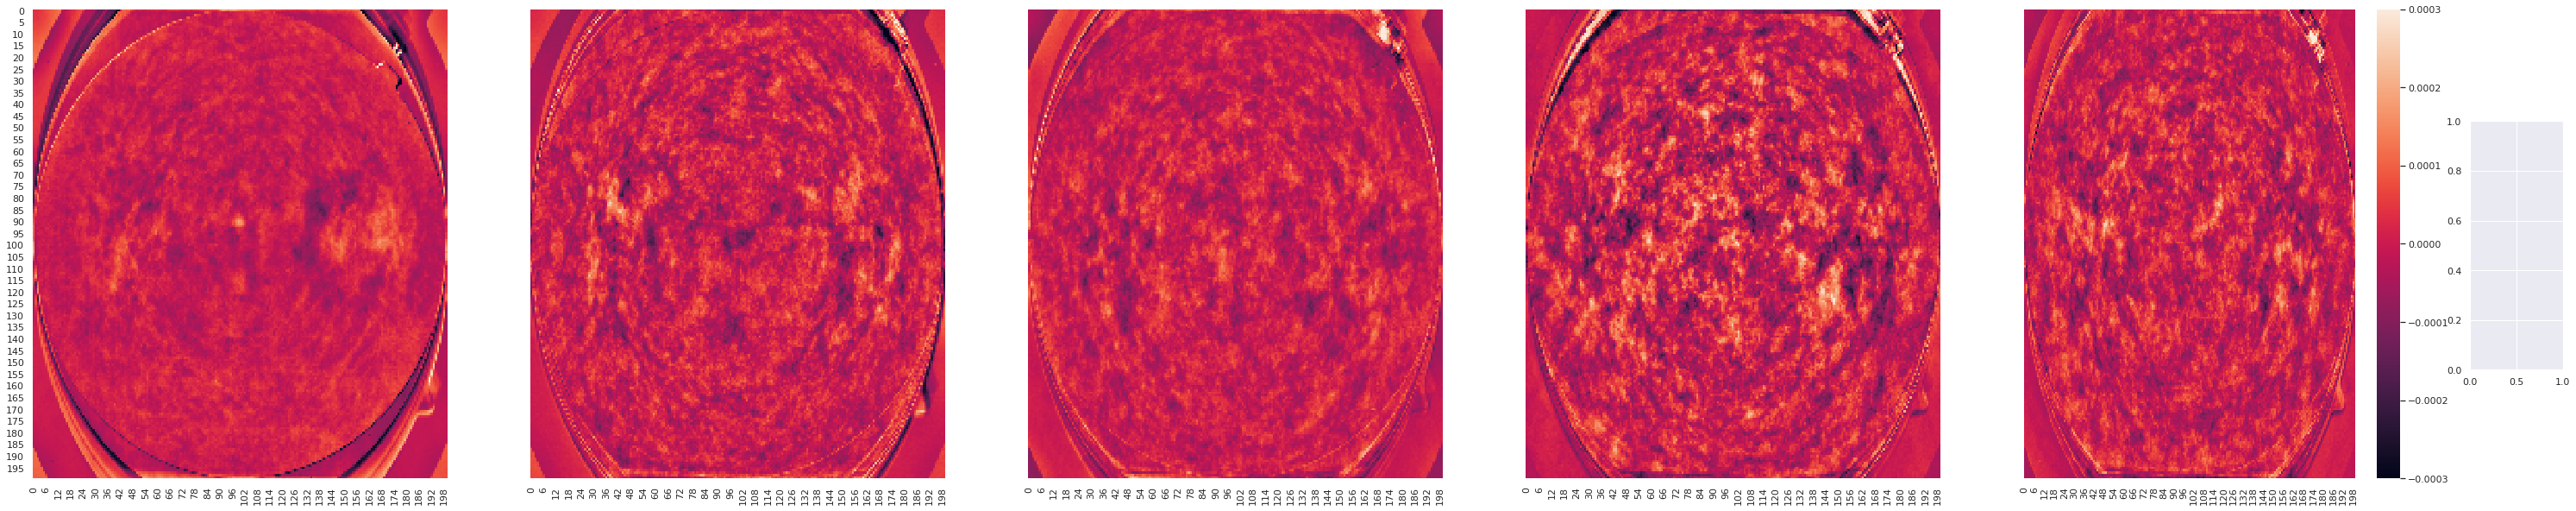

In [8]:
# fit the model with the training set
model_1.fit(x_train,y_train)

# create a heatmap of the coefficients
coeffs=model_1.coef_.reshape(5,images.shape[1],images.shape[2])

fig, axs = plt.subplots(1,5,sharex=True, sharey=True,figsize=(50, 10))
cbar_ax = fig.add_axes([.91,.3,.03,.4])
vmin = -0.0003
vmax = 0.0003
sns.heatmap(coeffs[0,:,:],ax=axs[0],vmin=vmin,vmax=vmax, cbar=False)
sns.heatmap(coeffs[1,:,:],ax=axs[1],vmin=vmin,vmax=vmax, cbar=False)
sns.heatmap(coeffs[2,:,:],ax=axs[2],vmin=vmin,vmax=vmax, cbar=False)
sns.heatmap(coeffs[3,:,:],ax=axs[3],vmin=vmin,vmax=vmax, cbar=False)
sns.heatmap(coeffs[4,:,:],ax=axs[4],vmin=vmin,vmax=vmax)

# save the plot
plt.savefig('logistic_regrssion_heat_map.png')

In [9]:
# threshold for greyscale value to be considered "bright"
threshold = 128

# features to be extracted from images
mean_pixel = np.zeros(X.shape[0]) # mean pixel value
var_pixel = np.zeros(X.shape[0]) # variance in pixel value
mean_bright = np.zeros(X.shape[0]) # mean pixel value that is bright
var_bright = np.zeros(X.shape[0]) # variance in pixel value that is bright

for i in range(X.shape[0]):
    mean_pixel[i]=np.mean(X[i,:])
    var_pixel[i]=np.var(X[i,:])
    img = X[i]
    mean_bright[i]=np.mean(img[np.where(img>threshold)])
    var_bright[i]=np.var(img[np.where(img>threshold)])

In [10]:
# features to be extracted from images
var_x = np.zeros(X.shape[0]) # variance along the x direction
var_y = np.zeros(X.shape[0]) # variance along the y direction

mean_x_bright = np.zeros(X.shape[0]) # average x corodinate that is bright
mean_y_bright = np.zeros(X.shape[0]) # average y corodinate that is bright

mean_x2y_bright = np.zeros(X.shape[0]) # average x^2 y corodinate that is bright
mean_xy2_bright = np.zeros(X.shape[0]) # average x*y^2 corodinate that is bright

mean_xy_bright = np.zeros(X.shape[0]) # average x*y corodinate that is bright
mean_x2y_bright = np.zeros(X.shape[0]) # average x^2 y corodinate that is bright

var_x_bright = np.zeros(X.shape[0]) # variance of x corodinate that is bright
var_y_bright = np.zeros(X.shape[0]) # variance of y corodinate that is bright

dist_bright_corner = np.zeros(X.shape[0]) # average distance from the corner (0,0) that is bright
dist_bright_center = np.zeros(X.shape[0]) # average distance from the center (100,100) that is bright

edge_x = np.zeros(X.shape[0]) # average x coordinate that is bright after appyling sobel edge kernel
edge_y = np.zeros(X.shape[0]) # average y coordinate that is bright after appyling sobel edge kernel

for i in range(X.shape[0]):
    img = X[i]
    img=img.reshape(image_size, image_size)
    
    # determine indices where the pixels are larger than the threshold
    y = np.where(img>threshold)[0]
    x = np.where(img>threshold)[1]
    
    var_y[i]=np.var(np.mean(img, axis=0))
    var_x[i]=np.var(np.mean(img, axis=1))
    mean_x_bright[i] = np.mean(x)
    mean_y_bright[i] = np.mean(y)
    mean_x2y_bright[i] = np.mean(x**2*y)
    mean_xy2_bright[i] = np.mean(x*y**2)
    mean_xy_bright[i] = np.mean(x*y)
    var_x_bright[i] = np.var(x)
    var_y_bright[i] = np.var(y)
    dist_bright_corner[i] = np.mean(np.sqrt(x**2+y**2))
    dist_bright_center[i] = np.mean(np.sqrt((x-100)**2+(y-100)**2))
    
    # sobel kernel enhances the edges of the image
    sobel_edge_kernel = np.array([[1,0,-1],
                               [2, 0, -2],
                               [-1, 0, 1]])
    
    # apply the kernel as a convolution
    edge_img=convolve(img, sobel_edge_kernel)
    
    y_edge = np.where(edge_img>threshold)[0]
    x_edge = np.where(edge_img>threshold)[1]
    
    # use 0 if there are no x coordinates that are bright
    if math.isnan(np.mean(x_edge)):
        edge_x[i] = 0
    else:
        edge_x[i] = np.mean(x_edge)
        
    # use 0 if there are no y coordinates that are bright
    if math.isnan(np.mean(y_edge)): 
        edge_y[i] = 0
    else:
        edge_y[i] = np.mean(y_edge)
    

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
# create dictionary of the features extracted
features_dict={
    'mean_pixel':mean_pixel,
    'var_pixel':var_pixel,
    'mean_bright':mean_bright,
    'var_bright':var_bright,
    'var_x':var_x,
    'var_y':var_y,
    'mean_x_bright':mean_x_bright,
    'mean_y_bright':mean_y_bright,
    'mean_x2y_bright':mean_x2y_bright,
    'mean_xy2_bright':mean_xy2_bright,
    'mean_xy_bright':mean_xy_bright,
    'mean_x2y_bright':mean_x2y_bright,
    'var_x_bright':var_x_bright,
    'var_y_bright':var_y_bright,
    'dist_bright_corner':dist_bright_corner,
    'dist_bright_center':dist_bright_center,
    'edge_x':edge_x,
    'edge_y':edge_y
}

# create dataframe from the above dictionary
df_features = pd.DataFrame(features_dict)
# save the dataframe as a csv file
df_features.to_csv('df_features.csv',index=False)

In [12]:
df_features.head()

,mean_pixel,var_pixel,mean_bright,var_bright,var_x,var_y,mean_x_bright,mean_y_bright,mean_x2y_bright,mean_xy2_bright,mean_xy_bright,var_x_bright,var_y_bright,dist_bright_corner,dist_bright_center,edge_x,edge_y
0,127.025975,489.651100,140.985178,400.655127,2.770372,31.861417,102.118074,97.832896,1.298612e+06,1.274727e+06,9812.210819,3185.900005,3183.548686,153.273232,75.204204,22.763466,94.953162
1,127.359225,611.492532,141.944641,418.945671,4.670770,45.277358,100.781255,97.685008,1.298098e+06,1.273748e+06,9819.001851,3169.930276,3160.573167,151.726830,75.266234,25.156627,97.681928
2,127.399750,485.787600,139.970535,371.891678,2.494616,36.056401,97.993569,99.209705,1.278542e+06,1.289812e+06,9765.820579,3214.882858,3220.716211,150.734674,75.516302,38.564165,98.515738
3,127.297675,697.840415,143.024204,334.828339,31.709346,29.359656,98.762514,98.638246,1.251108e+06,1.259173e+06,9754.778367,2855.641405,2976.079865,150.083515,72.625268,49.169717,92.778702
4,127.380325,226.150328,138.091003,153.443759,6.545797,11.371172,100.396079,100.934549,1.295434e+06,1.307972e+06,10146.379444,2748.987114,2818.732140,152.356473,70.895333,19.439394,86.878788


In [13]:
# construct training and testing set for the extracted feature data
x_train_features,x_test_features,y_train_features,y_test_features = train_test_split(df_features,Y_flat,test_size=0.2,random_state=random_state)

In [14]:
# construct logistic regression model
model_2 = LogisticRegression(class_weight="balanced")

# fit the model with the feature data
model_2.fit(x_train_features,y_train_features)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

In [26]:
# print coefficients
print(model_2.coef_, list(df_features.columns))

[[-1.58210165e-05  2.44808962e-03  1.58890676e-05  6.67033761e-04
   2.47124369e-04 -1.16871740e-04  8.08761920e-06 -2.82482124e-06
  -1.90882562e-05  2.25199256e-05  2.00513681e-03 -4.78945514e-03
  -3.70151692e-03 -9.48678315e-06 -4.96924063e-05  1.90089641e-04
  -5.07842810e-05]
 [ 4.17830251e-05 -4.99536648e-04  2.54608031e-05 -1.79997978e-04
  -1.07543726e-04  5.53369026e-05  1.94737789e-05  1.88591097e-05
   2.85679022e-06 -1.21443110e-05  4.07183485e-04  1.30869187e-03
   1.38548804e-03  3.28845820e-05  2.54099585e-05 -1.34063467e-04
   4.99636574e-06]
 [-9.84943967e-06 -3.06663240e-04 -1.94758638e-05  8.91421498e-05
  -6.51559765e-05  3.92067816e-05 -1.00007995e-05 -7.55998666e-06
   7.29984170e-06 -4.80909386e-06 -9.31223831e-04  1.14703389e-03
   8.75396759e-04 -9.71176486e-06  9.15733544e-06 -9.62869369e-06
   1.84834479e-05]
 [-1.08291040e-05 -9.52688300e-04 -1.08669970e-05 -1.88810984e-04
  -2.79238599e-05 -3.04803041e-06 -1.15976840e-05 -6.18659845e-06
   7.50902157e-06 -

In [16]:
# obtain prediction probabilities through 4 fold cross validation
y_pred_prob_model_2 = cross_val_predict(model_2, X, Y_flat, cv=k_fold, method='predict_proba')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [17]:
# save the prediction probabilities obtained as a csv
prob_to_csv(y_pred_prob_model_2, 'logisticregression_model2')
   

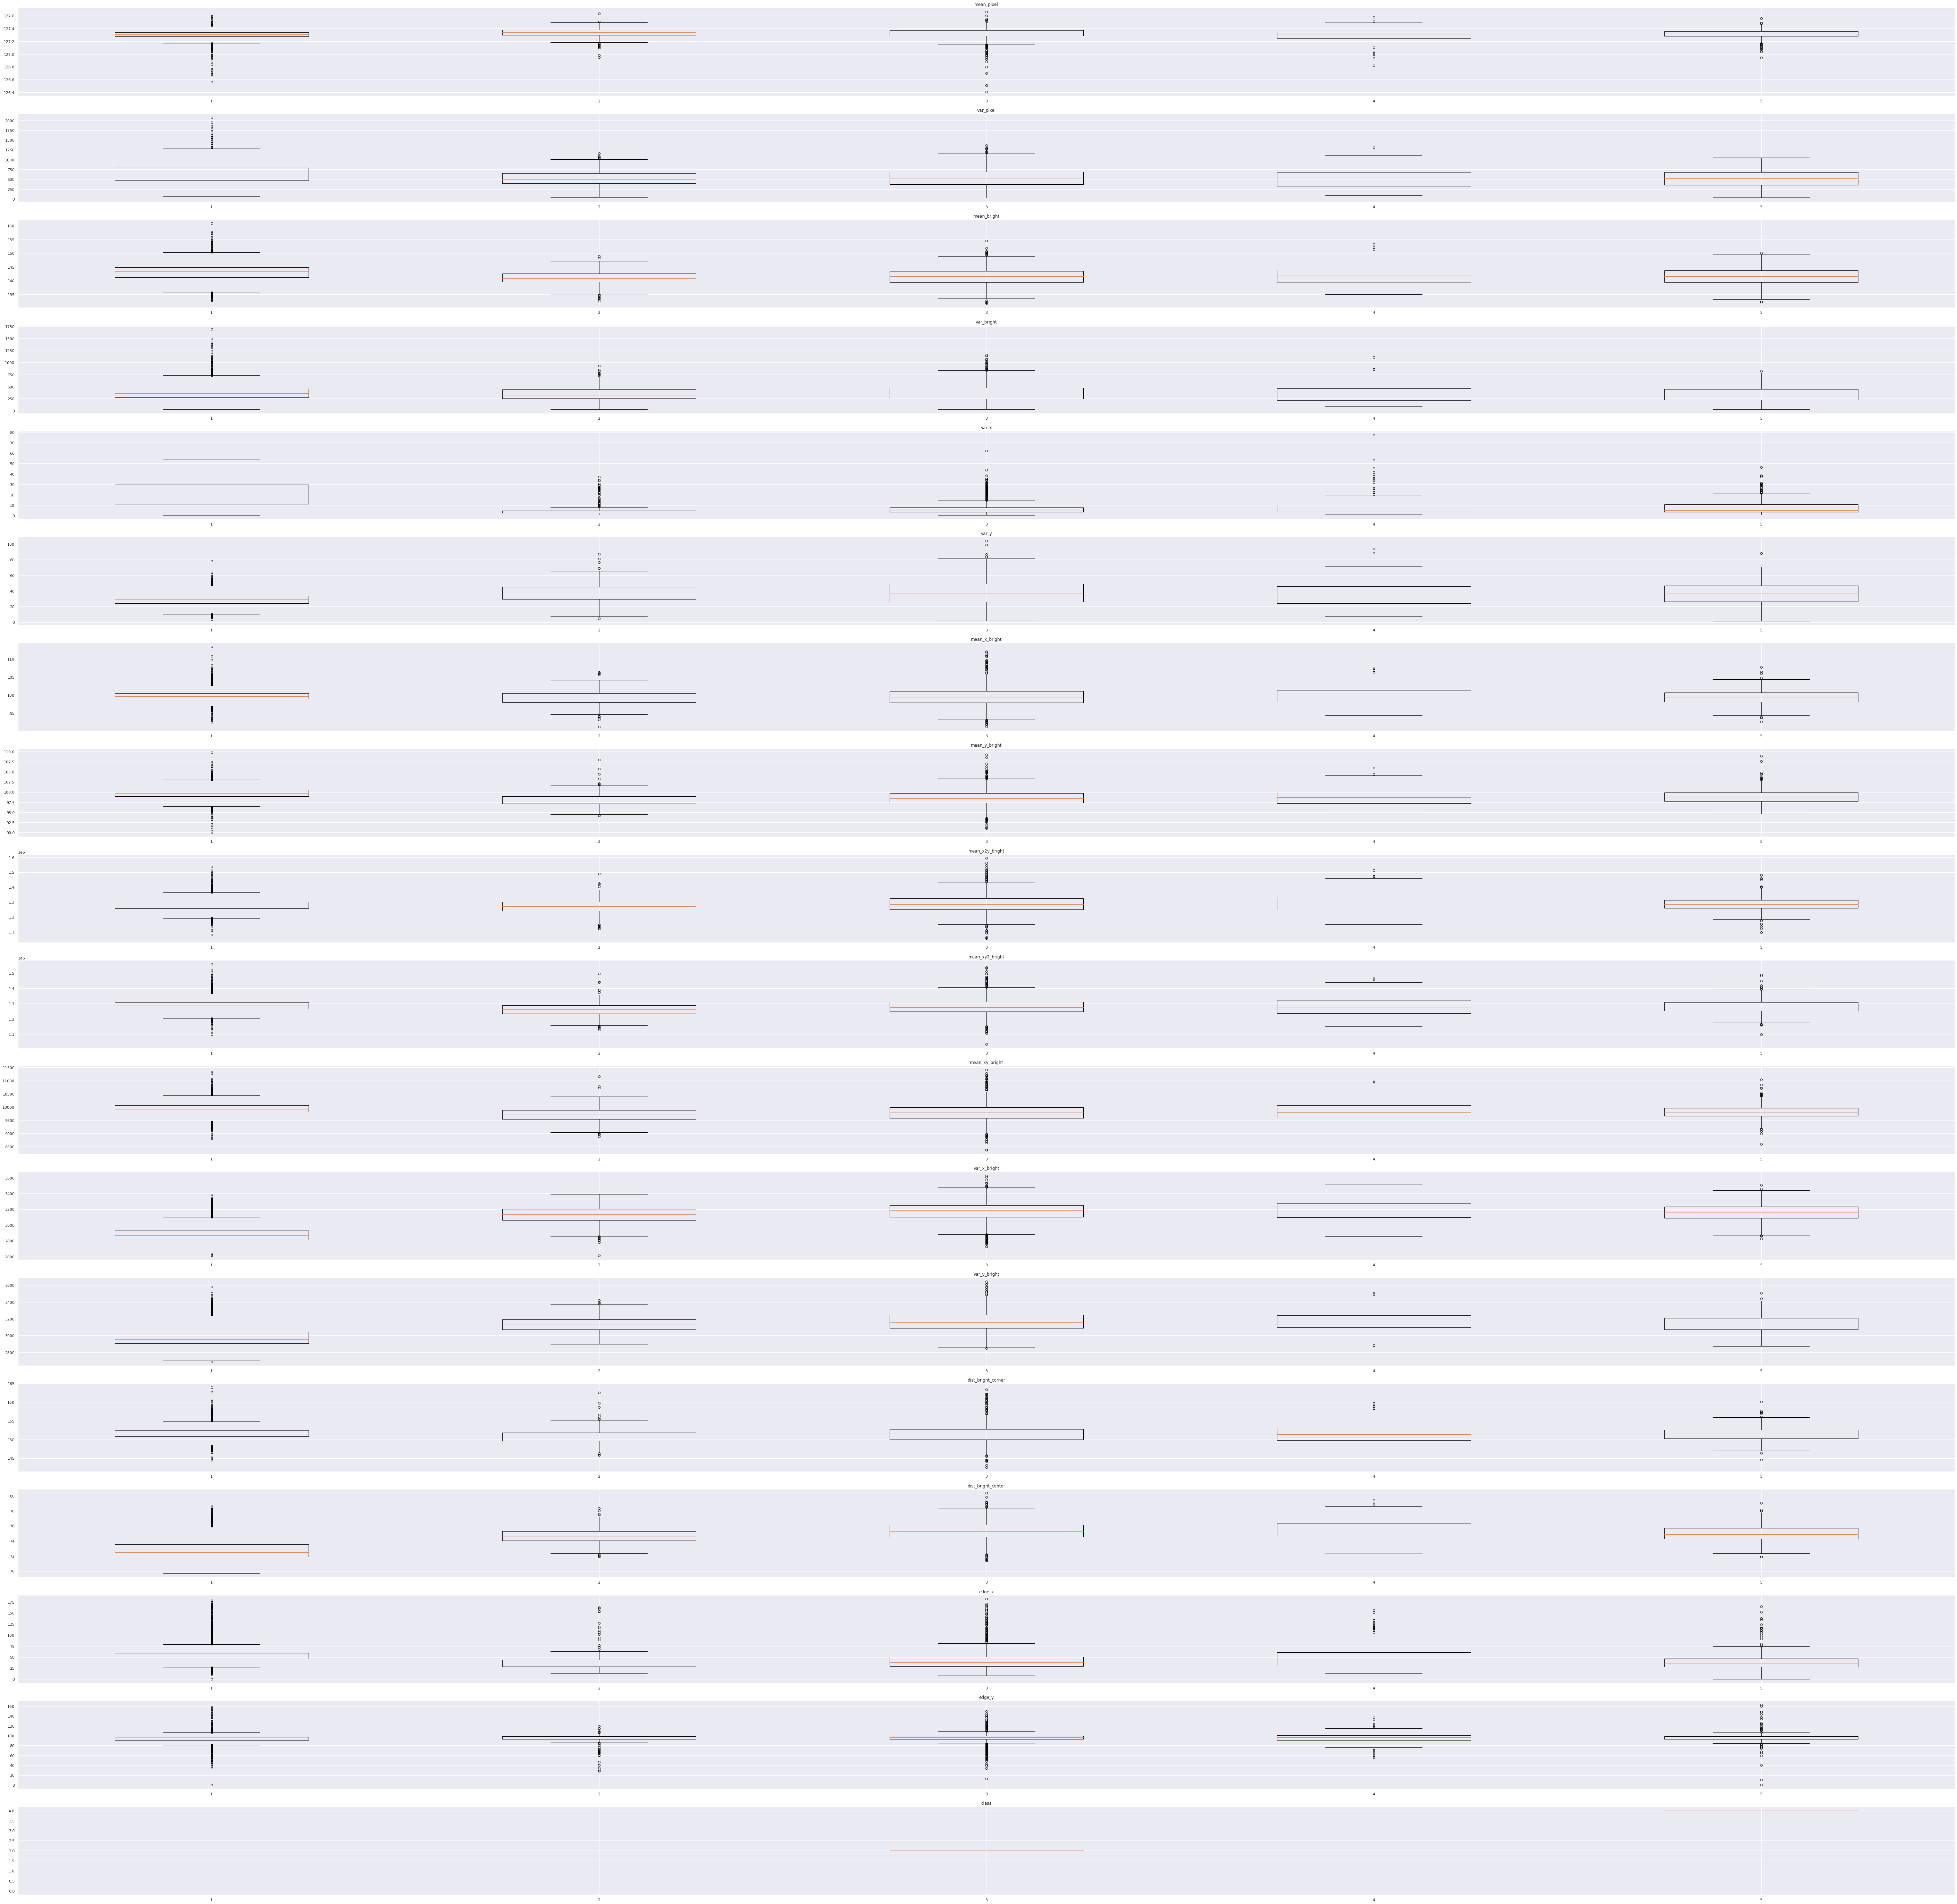

In [19]:
# construct box plots for all the extracted features

df_features['class']=Y_flat
df_features_0 = df_features.loc[df_features["class"] == 0]
df_features_1 = df_features.loc[df_features["class"] == 1]
df_features_2 = df_features.loc[df_features["class"] == 2]
df_features_3 = df_features.loc[df_features["class"] == 3]
df_features_4 = df_features.loc[df_features["class"] == 4]

variables = list(df_features.columns)
listof_df_features =[df_features_0,df_features_1,df_features_2,df_features_3,df_features_4]

fig, axs = plt.subplots(len(variables), figsize=(100,100))
for i in range(len(variables)):
    listof_feature = []
    for df in listof_df_features:
        listof_feature.append(df[variables[i]])
    axs[i].boxplot(listof_feature)
    axs[i].set_title(variables[i])

plt.savefig('feature_boxplots.png')

In [24]:
 def generate_features_boxplot(feature):
    '''
    takes in a string of a feature name and creates a boxplot for each class
    '''
    # list to store dataframe columns of features
    _temp_listof_features = []

    for df in listof_df_features:
            _temp_listof_features.append(df[feature])
    plt.boxplot(_temp_listof_features)
    plt.title(feature)


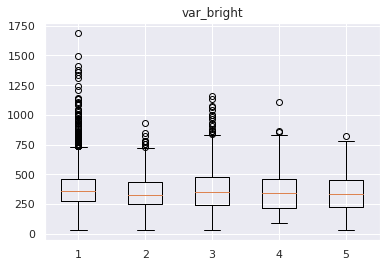

In [25]:
generate_features_boxplot('var_bright')

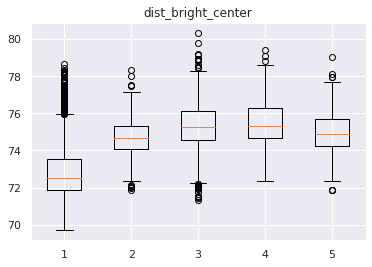

In [28]:
generate_features_boxplot('dist_bright_center')


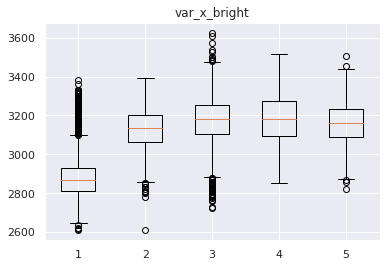

In [29]:
generate_features_boxplot('var_x_bright')

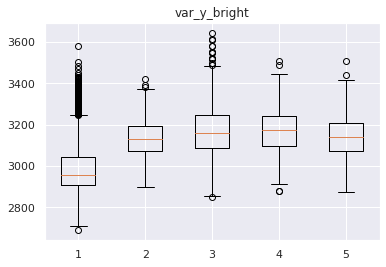

In [30]:
generate_features_boxplot('var_y_bright')

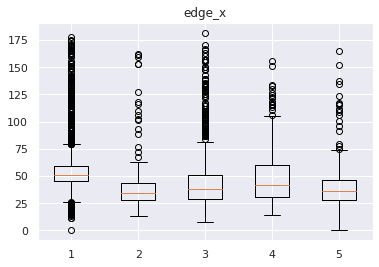

In [32]:
generate_features_boxplot('edge_x')

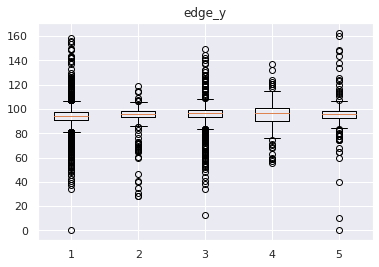

In [33]:
generate_features_boxplot('edge_y')